In [1]:
import numpy as np
import sys
import itertools
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from bisect import bisect_left
sys.path.append('../../') # Your path shouldcontain the parent GitHub repository

import wdtools

from astropy.io import fits

plt.style.use('vedant')

In [91]:
# Use wavelength and noise from a real spectrum with median SN ~ 40

with fits.open('sample_spectrum.fits') as f:
    real_flux = f[1].data['flux']
    real_wl = 10**f[1].data['loglam']
    real_ivar = f[1].data['ivar']
    
c1 = bisect_left(real_wl, 3750)
c2 = bisect_left(real_wl, 7000)

real_wl = real_wl[c1:c2].astype(float)
real_flux = real_flux[c1:c2].astype(float)
real_ivar = real_ivar[c1:c2]

In [92]:
from numba import njit
import time
sp = wdtools.SpecTools()


(19.19191919191924, 16.161616161616116)

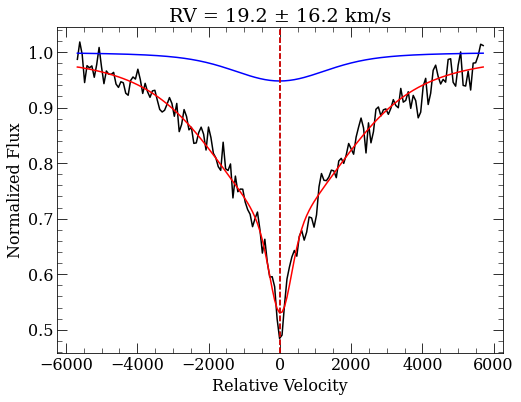

In [93]:
sp.get_line_rv(real_wl, real_flux, real_ivar, 6564.61, distance = 125, edge = 5, nmodel = 2, plot = True,
              lmfit_kw = dict(method = 'leastsq'))

(8.080808080808069, 12.282828282828287)

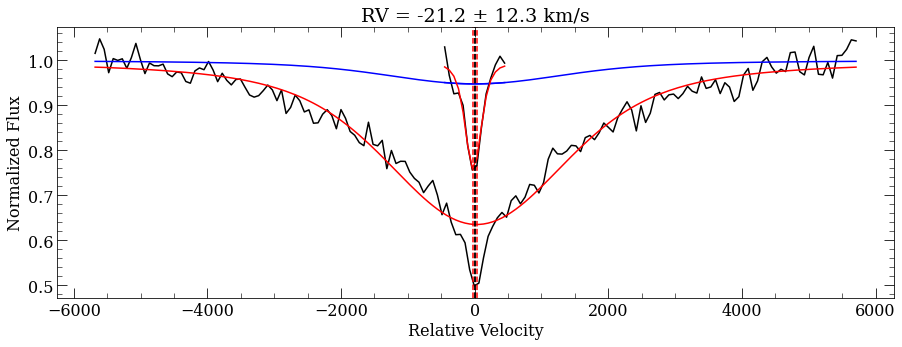

In [95]:
c = 2.99792458e5

def get_line_rv_2step(wl, fl, ivar, centroid, d1, e1, d2, e2, nmodel = 2, plot = False):
    rv1, e_rv1 = sp.get_line_rv(wl, fl, ivar, centroid, distance = d1, edge = e1, nmodel = nmodel, plot = plot)
    shiftwl = centroid * (1 + rv1 / c)
    srv2, e_rv2 = sp.get_line_rv(wl, fl, ivar, shiftwl, distance = d2, edge = e2, nmodel = nmodel, plot = plot)
    rv2 = rv1 + srv2
    return rv2, e_rv2

plt.figure(figsize = (15, 5))
get_line_rv_2step(real_wl, real_flux, real_ivar, 6564.61, 125, 25, 10, 2, nmodel = 2, plot = True)

In [89]:
rv1

29.292929292929244

In [96]:
rv2

8.080808080808069

In [97]:
rv2

8.080808080808069

In [98]:
srv2

-21.212121212121176

In [99]:
start = time.time()
sp.get_line_rv(real_wl, real_flux, real_ivar, 6564.61, distance = 125, edge = 5, nmodel = 2, plot = False)
end = time.time()

print("Elapsed (without numba) = %s" % (end - start))

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
sp.get_line_rv(real_wl, real_flux, real_ivar, 6564.61, distance = 125, edge = 5, nmodel = 2, plot = False)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
sp.get_line_rv(real_wl, real_flux, real_ivar, 6564.61, distance = 125, edge = 5, nmodel = 2, plot = False)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (without numba) = 0.2675771713256836
Elapsed (with compilation) = 0.2522768974304199
Elapsed (after compilation) = 0.2478792667388916


In [114]:
make_plot = False

gfp = wdtools.GFP(resolution = 2.5)

wl = real_wl.astype(float)

teff =  12000
logg = 8

N = 100
true_rvs = 150 * np.random.normal(size = N)

SNs = np.linspace(5, 50, 10)

base_fl = gfp.spectrum_sampler(wl, teff, logg)
base_fl = (base_fl / np.median(base_fl))


window = 100

100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


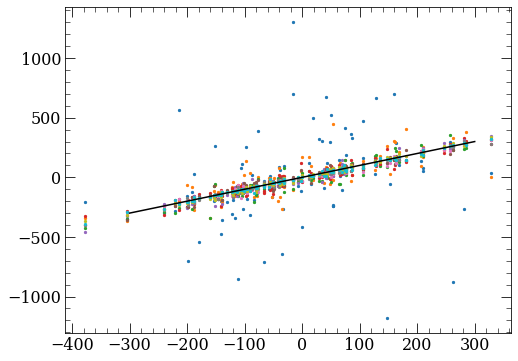

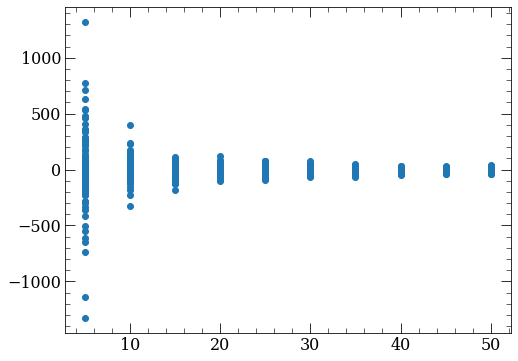

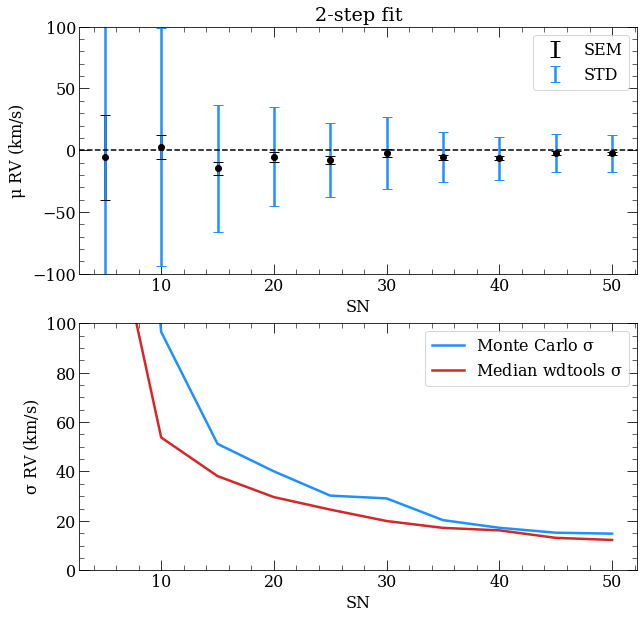

100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


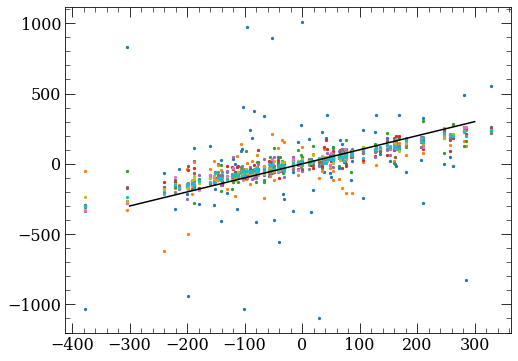

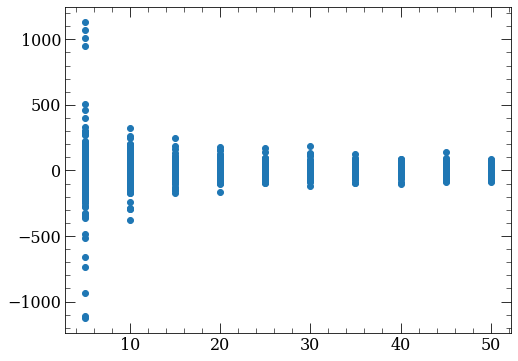

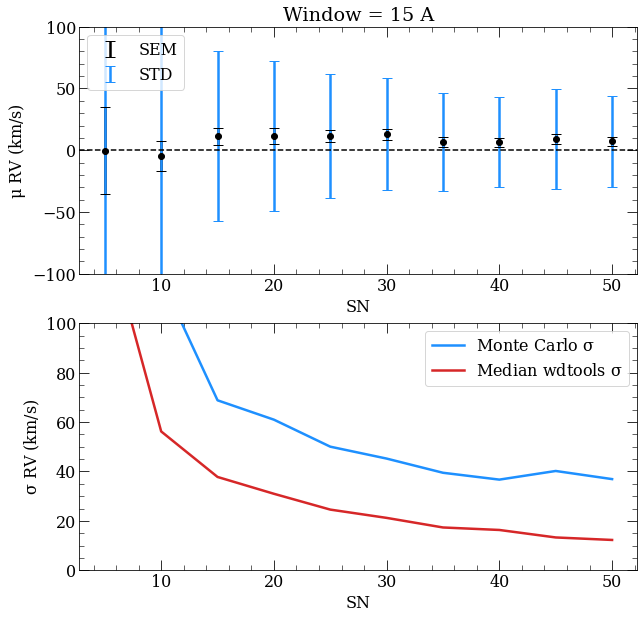

100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


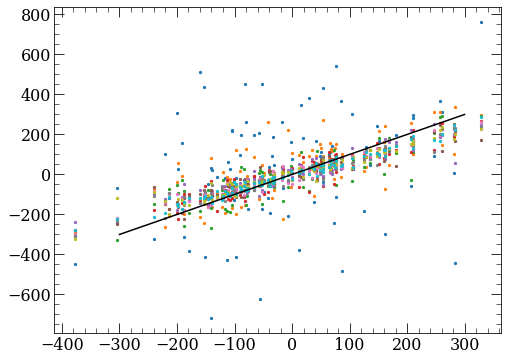

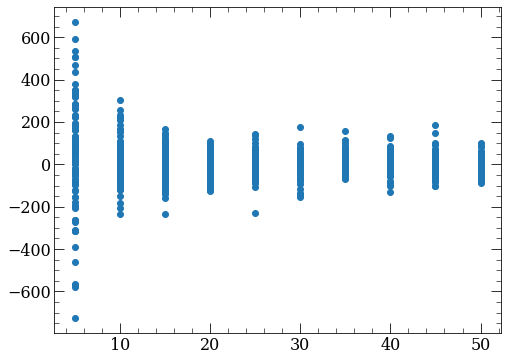

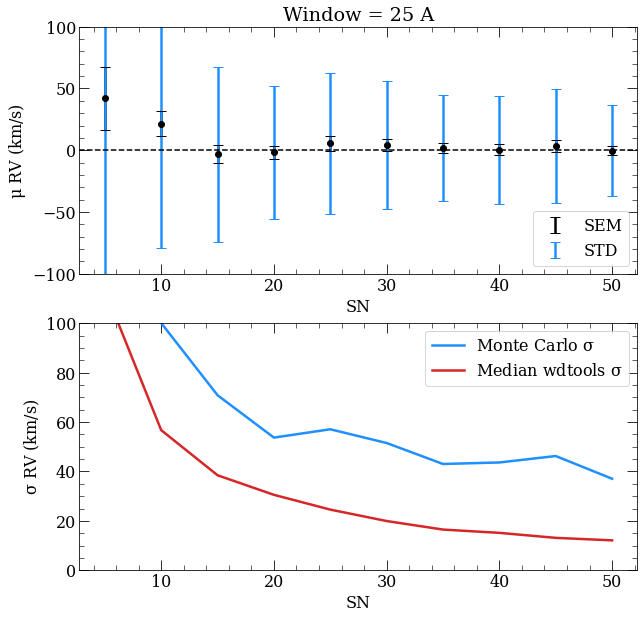

100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


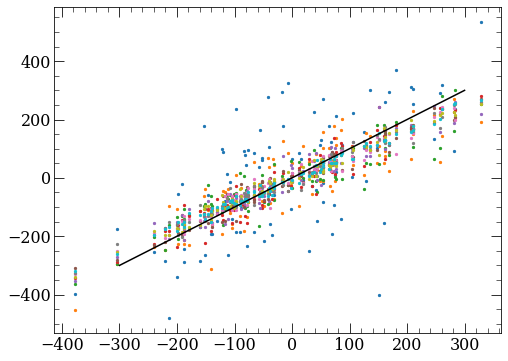

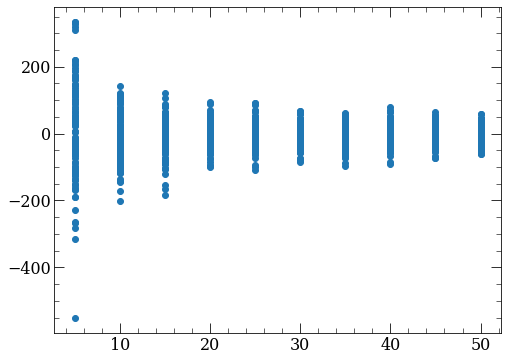

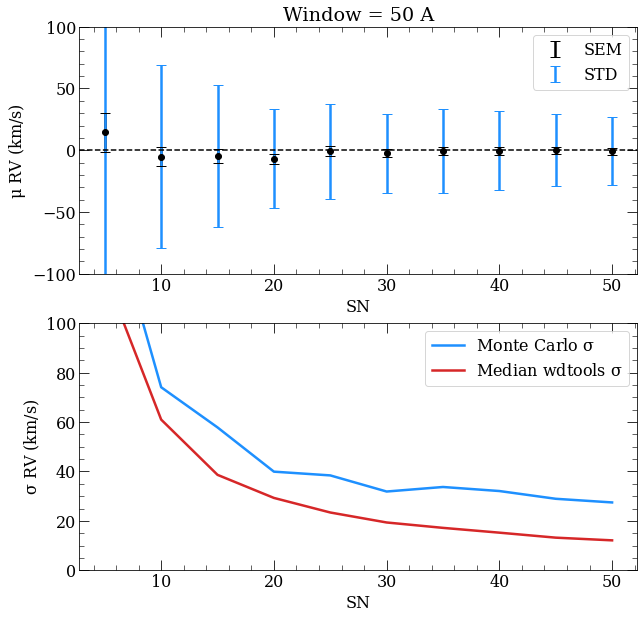

100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


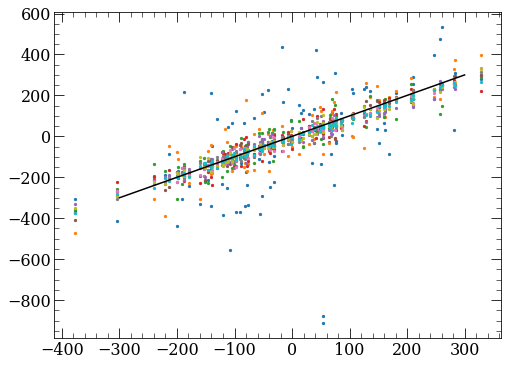

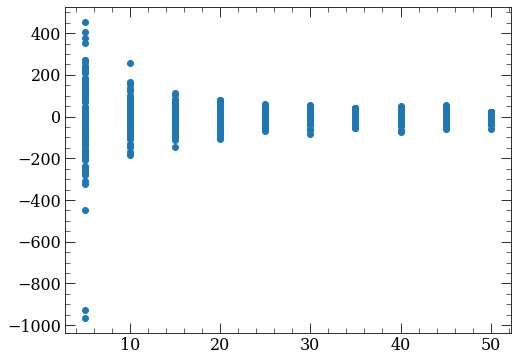

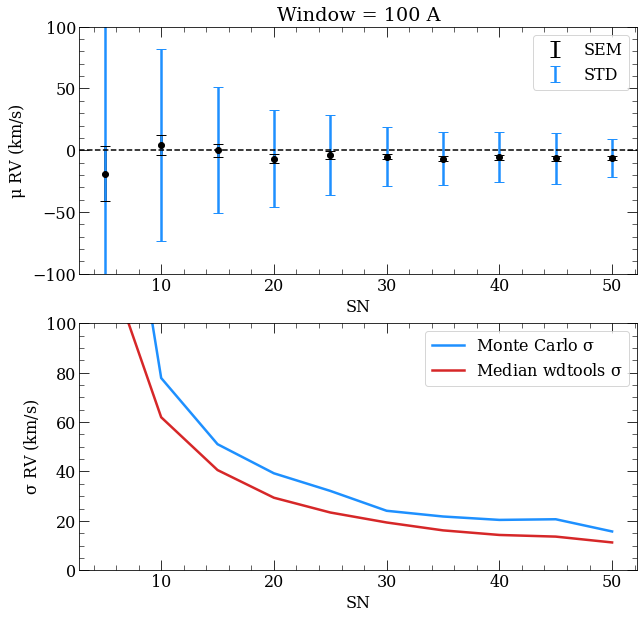

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


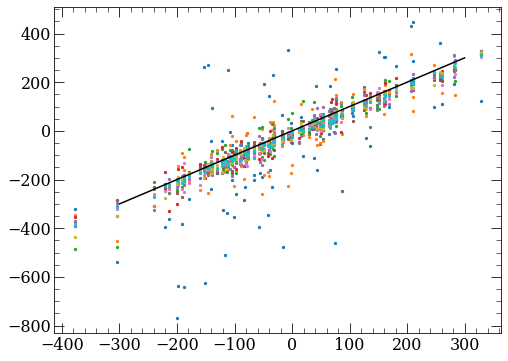

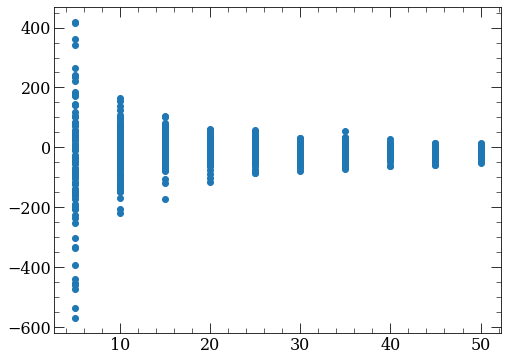

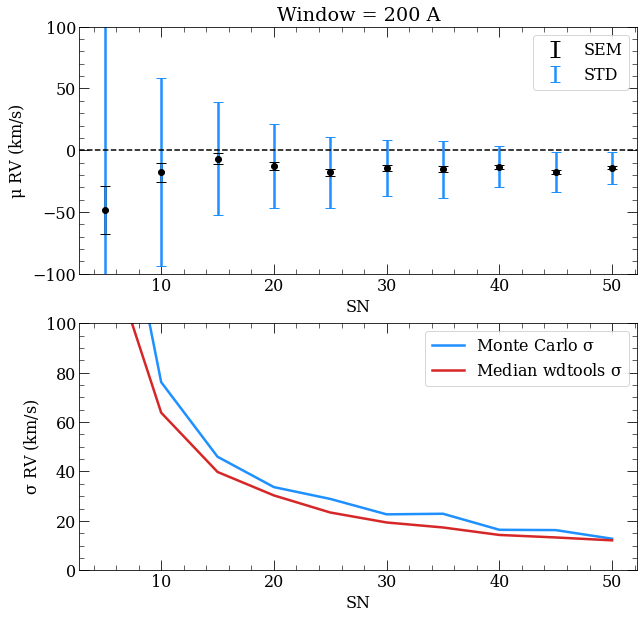

100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


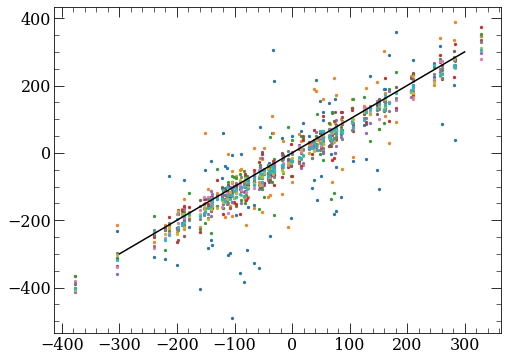

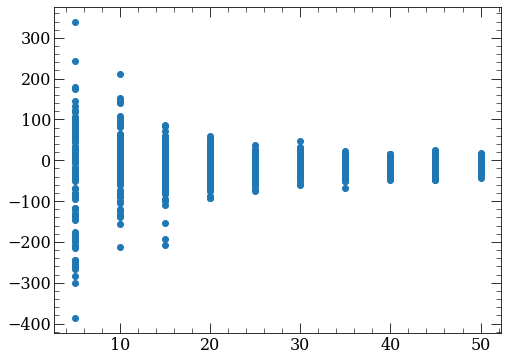

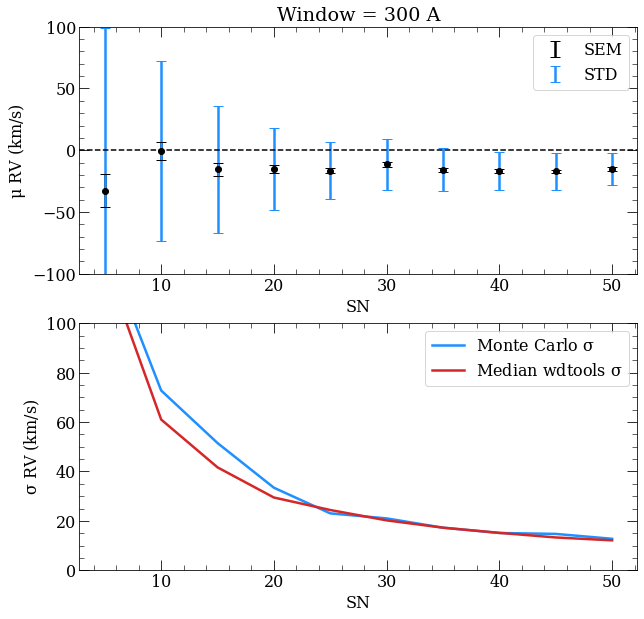

In [115]:
for window in [2, 15, 25, 50, 100, 200, 300]:

    rvs = [];
    e_rvs = [];
    plt.figure()
    for SN in (SNs):
        rvs_i = [];
        e_rvs_i = [];
        for true_rv in tqdm(true_rvs):
            fl = wdtools.spectrum.doppler_shift(wl, base_fl, true_rv).astype(float)
            sigma =  fl / SN 
            fl += sigma * np.random.normal(size = len(fl))
            ivar = (1 / sigma**2).astype(float)
            
            if window == 2:
                rv, e_rv = get_line_rv_2step(wl, fl, ivar, 
                                  6564.61, 250, 25, 15, 5, nmodel = 2, plot = False)
            else:
                rv, e_rv = sp.get_line_rv(wl, fl, ivar, 6564.61, distance = window, edge = window/5, 
                                          nmodel = 2, plot = False)
#             plt.show()
            rvs_i.append(rv)
            e_rvs_i.append(e_rv)
            #break
        rvs.append(rvs_i)
        e_rvs.append(e_rvs_i)
        
        plt.scatter(true_rvs, rvs_i, s = 5)
        
        #break
    plt.plot([-300, 300], [-300, 300], color = 'k')
    plt.show()
    
    rvs = np.array(rvs)
    e_rvs = np.array(e_rvs)

    rvs_cent = rvs - true_rvs

    plt.scatter(np.repeat(SNs, N), rvs_cent.ravel())

    mean_rv = np.mean(rvs_cent, 1)
    sem_rv = stats.sem(rvs_cent, axis = 1)
    std_rv = np.std(rvs_cent, 1)
    err_rv = np.median(e_rvs, 1)

    lw = 2.5

    plt.figure(figsize = (10, 10))

    plt.subplot(211)

    plt.errorbar(SNs, mean_rv, yerr = sem_rv, color = 'k', lw = lw, label = 'SEM', linestyle = 'None')
    plt.errorbar(SNs, mean_rv, yerr = std_rv, color = 'dodgerblue', lw = lw, linestyle = 'none', label = 'STD')
    plt.scatter(SNs, mean_rv, color = 'k', zorder = 10)
    plt.ylabel('$\mu$ RV (km/s)')
    plt.xlabel('SN')
    plt.ylim(-100, 100)
    plt.axhline(0, color = 'k', linestyle = '--')
    plt.legend()
    if window != 2:
        plt.title('Window = %i A' % window)
    elif window == 2:
        plt.title('2-step fit')

    plt.subplot(212)

    plt.plot(SNs, std_rv, color = 'dodgerblue', lw = lw, label = 'Monte Carlo $\sigma$')
    plt.plot(SNs, err_rv, color = 'tab:red', lw = lw, label = 'Median wdtools $\sigma$')

    plt.legend()

    plt.xlabel('SN')
    plt.ylabel('$\sigma$ RV (km/s)')

    plt.ylim(0, 100)

    plt.savefig('rvfits/rvfits_d%iA.jpg' % window)
    plt.show()

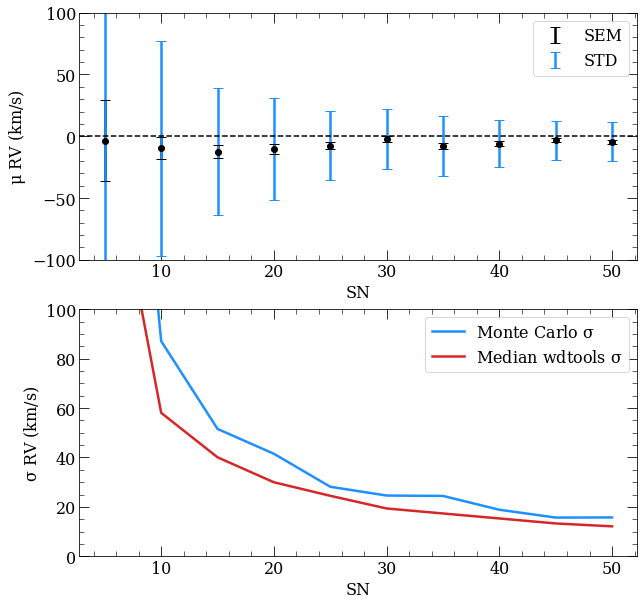

In [110]:
plt.figure(figsize = (10, 10))

plt.subplot(211)

plt.errorbar(SNs, mean_rv, yerr = sem_rv, color = 'k', lw = lw, label = 'SEM', linestyle = 'None')
plt.errorbar(SNs, mean_rv, yerr = std_rv, color = 'dodgerblue', lw = lw, linestyle = 'none', label = 'STD')
plt.scatter(SNs, mean_rv, color = 'k', zorder = 10)
plt.ylabel('$\mu$ RV (km/s)')
plt.xlabel('SN')
plt.ylim(-100, 100)
plt.axhline(0, color = 'k', linestyle = '--')
plt.legend()

plt.subplot(212)

plt.plot(SNs, std_rv, color = 'dodgerblue', lw = lw, label = 'Monte Carlo $\sigma$')
plt.plot(SNs, err_rv, color = 'tab:red', lw = lw, label = 'Median wdtools $\sigma$')

plt.legend()

plt.xlabel('SN')
plt.ylabel('$\sigma$ RV (km/s)')

plt.ylim(0, 100)

plt.savefig('rvfits/rvfits_d%iA.jpg' % window)
plt.show()

In [21]:
mean_sigma = np.mean(np.sqrt(resid**2), 1)
sigma_sigma = np.(np.sqrt(resid**2), 1)

array([205.03294097,  21.22968529,  18.5064051 ,  12.70970865,
         8.4873929 ])

In [8]:
def get_qlines(x, y, N = 8):
    #bins = np.linspace(x.min() - 0.1 * np.median(x), x.max() + 0.1 * np.median(x), N)
    bins = N
    bs = stats.binned_statistic(x, y, bins = bins, statistic = np.mean)
    median = bs.statistic
    midpoints = bs.bin_edges[:-1] + np.diff(bs.bin_edges)[0]/2

    upper = stats.binned_statistic(x, y, bins = bins, statistic = lambda t: np.quantile(t, 0.84)).statistic
    lower = stats.binned_statistic(x, y, bins = bins, statistic = lambda t: np.quantile(t, 0.16)).statistic
    
    return midpoints, median, lower, upper

Text(0, 0.5, 'RV')

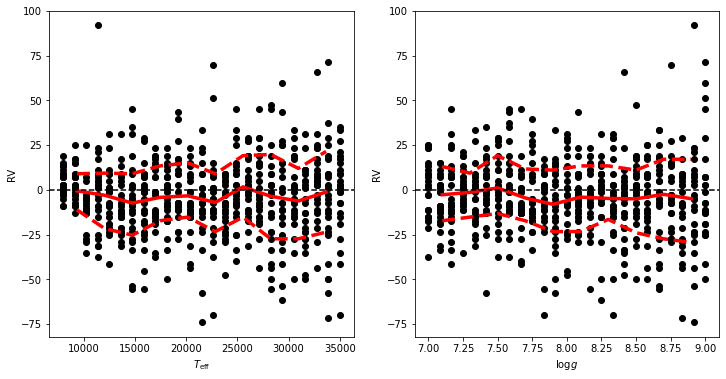

In [9]:
plt.figure(figsize = (12, 6))

N = 10
lw = 3.5 

#-----------------------------------

x = param_grid[:, 0]
y = rvs
mid, med, lo, hi = get_qlines(x, y, N)

plt.subplot(121)
plt.scatter(x, y, color = 'k')
plt.plot(mid, med, 'r', lw = lw)
plt.plot(mid, lo, 'r--', lw = lw)
plt.plot(mid, hi, 'r--', lw = lw)
plt.axhline(0, color = 'k', linestyle = '--')
plt.xlabel('$T_{\mathrm{eff}}$')
plt.ylabel('RV')

#-----------------------------------

x = param_grid[:, 1]
y = rvs
mid, med, lo, hi = get_qlines(x, y, N)

plt.subplot(122)
plt.scatter(x, y, color = 'k')
plt.plot(mid, med, 'r', lw = lw)
plt.plot(mid, lo, 'r--', lw = lw)
plt.plot(mid, hi, 'r--', lw = lw)
plt.axhline(0, color = 'k', linestyle = '--')
plt.xlabel('$\log{g}$')
plt.ylabel('RV')

Text(0.5, 1.0, '$\\mu$ = -3 km/s, $\\sigma$ = 20 km/s')

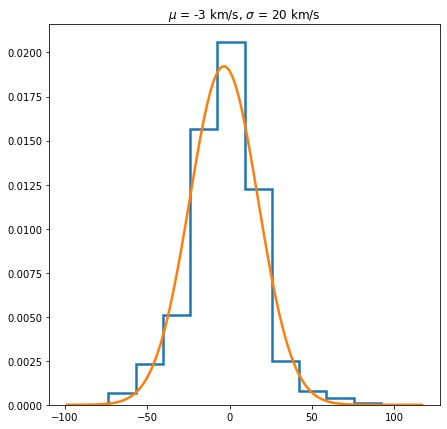

In [10]:
plt.figure(figsize = (7,7))

plt.hist(rvs, histtype = 'step', density = True, lw = 2.5)
gs = stats.norm.fit(rvs)

rvgrid = np.linspace(rvs.min() - 25, rvs.max() + 25, 100)

plt.plot(rvgrid, stats.norm.pdf(rvgrid, loc = gs[0], scale = gs[1]), lw = 2.5)

plt.title(r'$\mu$ = %i km/s, $\sigma$ = %i km/s' % (gs[0], gs[1]))